# Идентификация интернет-пользователей

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
import os
import pickle
import numpy as np
import pandas as pd
import math
import datetime
from scipy.sparse import csr_matrix
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier, LogisticRegression, LogisticRegressionCV
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer
from itertools import combinations
from tqdm import tqdm_notebook
from sklearn.utils import resample
from matplotlib import pyplot as plt
%matplotlib inline

## Цели и задачи проекта

Цель проекта – реализовать систему по идентификации пользователя в интернете по истории его браузера.

Задачи:
1. Формализация.
2. Анализ и обработка исходных данных.
3. Создание и обработка новых признаков.
4. Выбор модели.
5. Обучение и подбор гиперпараметров.
6. Корсс-валидация и анализ результатов.

## Формализация

Формально, решаем задачу бинарной классификации (наш пользователь или не наш) на основе истории браузера.

Судить будем по интернет сессиям. Сессия – последовательность из не более чем 10 посещений сайтов подряд, произошедших не более чем за полчаса.

Метрикой качества выбрали ROC AUC.

## Исходные данные и признаки

Исходные данные – файлы со всей доступной историей браузера пользователей. На каждого пользователя свой единственный файл формата csv. Файл содержащит последовательные записи адреса и времени посещения.

Пример части такого файла:

In [2]:
PATH_TO_DATA = ('/home/dniwe/work_dir/mlmipt/final/capstone_user_identification')
with open(os.path.join(PATH_TO_DATA, '3users/user0001.csv')) as f:
    for _ in range(5):
        print(f.readline()[:-1])

timestamp,site
2013-11-15 09:28:17,vk.com
2013-11-15 09:33:04,oracle.com
2013-11-15 09:52:48,oracle.com
2013-11-15 11:37:26,geo.mozilla.org


Также дан файл с сериализированным словарем, кодирующим идентификаторами адреса сайтов

### Обработка исходных данных

Был реализован ряд функций для извлечения сессий из файлов. Имеется возможность указать желаемую длину сессии как по времени, так и по числу сайтов. Также предусмотрен выбор шага между началами последовательных сессий.

In [3]:
PATH_TO_RAW_DATA = os.path.join(PATH_TO_DATA, '../train')
raw_Alice = pd.DataFrame().from_csv(os.path.join(PATH_TO_RAW_DATA, 'Alice_log.csv'), index_col=None).sort_values('timestamp').reset_index(drop=True)
with open(os.path.join(PATH_TO_RAW_DATA, 'site_dic.pkl'), 'rb') as f:
    sites = pickle.load(f)

#парсим дату из timestamp
def get_date_time_from_str(timestamp):
    return datetime.datetime(int(timestamp[0:4]), int(timestamp[5:7]), int(timestamp[8:10]), int(timestamp[11:13]), int(timestamp[14:16]), int(timestamp[17:19]))

#вытягиваем сессии из сырого датафрейма с нужными параметрами
def get_sessions(df, sites_dict, sites_amnt=10, time_limit=datetime.timedelta(minutes=30), step=10, target=0):
    
    #формируем колонки для финального датафрейма в зависимости от количества сайтов в сессии
    columns = []
    for i in range(sites_amnt):
        columns.append('site' + str(i+1))
        columns.append('time' + str(i+1))
    columns.append('target')
    
    #переводим таймстемпы в datetime
    df['date_time'] = df['timestamp'].apply(get_date_time_from_str)
    
    #извлекаем сессии
    sessions_arr = []
    for i in range(0, len(df), step):
        #берем нужное число сайтов
        temp_df = df.iloc[i:i+sites_amnt, [1,2]]
        #выкидываем лишние по времени
        temp_df = temp_df[temp_df['date_time'] - temp_df.iloc[0,-1] <= time_limit]
        new_session = []
        #заполняем данные новой сессии
        for j in range(len(temp_df)):
            new_session.append(sites_dict[temp_df.iloc[j,0]])
            new_session.append(temp_df.iloc[j,1])
        #заполняем пустоты
        for j in range(len(new_session) // 2, sites_amnt):
            new_session.append(np.NaN)
            new_session.append(np.NaN)
        #добавляем идентификатор пользователя (наш / не наш)
        new_session.append(target)
        #записываем новую сессию
        sessions_arr.append(new_session)
    #формируем датафрейм и возвращаем его
    sessions_df = pd.DataFrame(sessions_arr, columns=columns)
    return sessions_df

#делаем из всех данных об Элис (целевой пользователь) получасовые сессии длиной 10 с шагом 10
def make_Alice_train(out_path, path, dict_path, sites_amnt=10, time_limit=datetime.timedelta(minutes=30), step=10):
    raw_Alice = pd.DataFrame().from_csv(path, index_col=None).sort_values('timestamp').reset_index(drop=True)
    sites = pickle.load(open(dict_path, 'rb'))
    extracted_Alice = get_sessions(raw_Alice, sites, sites_amnt, time_limit, step, 1)
    with open(out_path, 'wb') as Alice_train_pkl:
        pickle.dump(extracted_Alice, Alice_train_pkl, protocol=2)
        
#такие же сессии делаем для нецелевых пользователей
def make_not_Alice_train(out_path, path_exp, dict_path, sites_amnt=10, time_limit=datetime.timedelta(minutes=30), step=10):
    sites = pickle.load(open(dict_path, 'rb'))
    extracted = []
    for filename in tqdm_notebook(glob(path_exp)):
        raw = pd.DataFrame().from_csv(filename, index_col=None).sort_values('timestamp').reset_index(drop=True)
        extracted.append(get_sessions(raw, sites, sites_amnt, time_limit, step, 0))
    result = pd.concat(extracted).sort_values('time1').reset_index(drop=True)
    with open(out_path, 'wb') as not_Alice_train_pkl:
        pickle.dump(result, not_Alice_train_pkl, protocol=2)



In [4]:
"""
make_Alice_train(os.path.join(PATH_TO_RAW_DATA, 'Alice_train_step1_limit30m.pkl'),
                 os.path.join(PATH_TO_RAW_DATA, 'Alice_log.csv'),
                 os.path.join(PATH_TO_RAW_DATA, 'site_dic.pkl'), 
                 step=1)

make_not_Alice_train(os.path.join(PATH_TO_RAW_DATA, 'not_Alice_train_step1_limit30m.pkl'),
                     os.path.join(PATH_TO_RAW_DATA, 'other_user_logs/*.csv'),
                     os.path.join(PATH_TO_RAW_DATA, 'site_dic.pkl'), 
                     step=1)
"""

"\nmake_Alice_train(os.path.join(PATH_TO_RAW_DATA, 'Alice_train_step1_limit30m.pkl'),\n                 os.path.join(PATH_TO_RAW_DATA, 'Alice_log.csv'),\n                 os.path.join(PATH_TO_RAW_DATA, 'site_dic.pkl'), \n                 step=1)\n\nmake_not_Alice_train(os.path.join(PATH_TO_RAW_DATA, 'not_Alice_train_step1_limit30m.pkl'),\n                     os.path.join(PATH_TO_RAW_DATA, 'other_user_logs/*.csv'),\n                     os.path.join(PATH_TO_RAW_DATA, 'site_dic.pkl'), \n                     step=1)\n"

Организаторы соревнования на kaggle дали свои готовые датафреймы на основе сырых данных. Далее идет работа с данными из соревнования, потому что из сырых данных (пока) извлечь пользу не удалось.

### Исходные данные kaggle соревнования

В [соревновании](https://www.kaggle.com/c/catch-me-if-you-can-intruder-detection-through-webpage-session-tracking2/) предоставлены уже сформрованные сессии целевого и нецелевых пользователей со словарем сайтов. Сессия представляет собой последовательность идентификаторов сайтов с датой их посещения с точностью до секунды. Каждая сессия длиной не более 30 минут и состоит не более чем из 10 сайтов.

Пример части обучающей выборки:

In [5]:
with open(os.path.join(PATH_TO_DATA, 'train_sessions.csv')) as f:
    for _ in range(5):
        print(f.readline()[:-1])

session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,site6,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
1,718,2014-02-20 10:02:45,,,,,,,,,,,,,,,,,,,0
2,890,2014-02-22 11:19:50,941,2014-02-22 11:19:50,3847,2014-02-22 11:19:51,941,2014-02-22 11:19:51,942,2014-02-22 11:19:51,3846,2014-02-22 11:19:51,3847,2014-02-22 11:19:52,3846,2014-02-22 11:19:52,1516,2014-02-22 11:20:15,1518,2014-02-22 11:20:16,0
3,14769,2013-12-16 16:40:17,39,2013-12-16 16:40:18,14768,2013-12-16 16:40:19,14769,2013-12-16 16:40:19,37,2013-12-16 16:40:19,39,2013-12-16 16:40:19,14768,2013-12-16 16:40:20,14768,2013-12-16 16:40:21,14768,2013-12-16 16:40:22,14768,2013-12-16 16:40:24,0
4,782,2014-03-28 10:52:12,782,2014-03-28 10:52:42,782,2014-03-28 10:53:12,782,2014-03-28 10:53:42,782,2014-03-28 10:54:12,782,2014-03-28 10:54:42,782,2014-03-28 10:55:12,782,2014-03-28 10:55:42,782,2014-03-28 10:56:12,782,2014-03-28 10:56:42,0


### Анализ исходных данных

In [6]:
train_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'train_sessions.csv'),
                       index_col='session_id')

test_df = pd.read_csv(os.path.join(PATH_TO_DATA, 'test_sessions.csv'),
                      index_col='session_id')

train_df.sort_values('time1', inplace=True)
train_df.reset_index(drop=True, inplace=True)

Посмотрим на временные промежутки, представленные в обучающей и тестовой выборке.

In [7]:
print('Обучающая: от {} до {}. Всего {} сессий.'.format(train_df['time1'].values.min(),
                                                 train_df['time1'].values.max(),
                                                 len(train_df)))

print('Целевые сессии: от {} до {}. Всего {} сессий.'.format(train_df[train_df['target'] == 1]['time1'].values.min(),
                                                 train_df[train_df['target'] == 1]['time1'].values.max(),
                                                 len(train_df[train_df['target'] == 1])))

print('Тестовая: от {} до {}. Всего {} сессий.'.format(test_df['time1'].values.min(),
                                                      test_df['time1'].values.max(),
                                                     len(test_df)))

Обучающая: от 2013-01-12 08:05:57 до 2014-04-30 23:39:53. Всего 253561 сессий.
Целевые сессии: от 2013-02-12 16:25:10 до 2014-04-15 18:07:48. Всего 2297 сессий.
Тестовая: от 2014-05-01 17:14:03 до 2014-12-05 23:26:53. Всего 82797 сессий.


На обучение даны сессии на протяжении 16 месяцев. На тест даны сесии за последующие 7 месяцев. Видно, что целевых сессий на два порядка меньше нецелевых. 

In [8]:
train_df['time1_int'] = train_df['time1'].apply(lambda x: int(x.replace('-', '').replace(':', '').replace(' ', '')))
print(train_df[['time1_int', 'target']].corr(method='spearman'))
train_df.drop(columns='time1_int', inplace=True)

           time1_int    target
time1_int   1.000000 -0.020892
target     -0.020892  1.000000


Близкое к нулю значение ранговой корреляции между датой сессии и таргетом показывает, что целевые и нецелевые сессии неплохо перемешаны во времени.

## Создание и обработка новых признаков

В финальную модель были включены следующие признаки:

* Набор сайтов в сессии. Пропуски заменены на 0.
* Склеенные год, месяц, день сессии
* Логарифм временного размаха сессии
* Индикатор "летней" сессии
* Индикатор того, что время начала сессии входит в типичное для целевых сессий
* День недели в формате one hot encoding

Из тренировочных данных были выброшены сессии раньше июня 2013 года.

Все количественные признаки были отмасштабированны вычитанием среднего и делением на СКО.

К сайтам в сессии был применен подход bag of words с мерой tf-idf на биграммах.

Код и объяснения этих шагов даны ниже.

In [9]:
#функция для записи предсказаний в соревновании
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

#час начала сессии
def start_hour(time):
    if time == 'nan':
        return -1
    return int(time[-8:-6])

#день недели
def weekday(time):
    if time == 'nan':
        return -1
    return datetime.datetime(int(time[0:4]), int(time[5:7]), int(time[8:10])).weekday()

#функция для перевода сессии в строковый формат с пропуском нулей
def history_string(df):
    sites = df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int').astype('str')
    strings = []
    for i in tqdm_notebook(range(len(df))):
        session = sites.iloc[i, :].values
        temp = ''
        for site in session:
            if str(site) == '0':
                break
            temp += str(site) + ' '
        strings.append(temp)
    return strings
"""
функция для подсчета количества сайтов в сессии,
доли уникальных сайтов (не вошла в финальную модель),
врменного размаха сессии с его прологарифмированным вариантом
"""
def session_len__unique_part__delta(df):
    session_len = []
    unique_part = []
    delta = []
    log_delta = []
    sites = df[['site%d' % i for i in range(1, 11)]].fillna(0).astype('int')
    times = df[['time%d' % i for i in range(1, 11)]].fillna(0).astype('str')
    for i in tqdm_notebook(range(len(df))):
        session = sites.iloc[i, :].values
        session_len.append(len(session[session != 0]))
        
        unique_part.append(len(np.unique(session[session != 0])))
        
        time = times.iloc[i, 0]
        a = datetime.datetime(int(time[0:4]), int(time[5:7]), int(time[8:10]), int(time[11:13]), int(time[14:16]), int(time[17:19]))
        time = times.iloc[i, session_len[-1] - 1]
        b = datetime.datetime(int(time[0:4]), int(time[5:7]), int(time[8:10]), int(time[11:13]), int(time[14:16]), int(time[17:19]))
        delta.append((b-a).total_seconds())
        l_delta = np.log(delta[-1])
        if l_delta != -np.inf:
            log_delta.append(l_delta)
        else:
            log_delta.append(0)
    return session_len, unique_part, delta, log_delta

#склеенные год, месяц и число сессии
def session_date(time):
    if time == 'nan':
        return -1
    return int(time[0:4] + time[5:7] + time[8:10])

#индикатор "летней" сессии    
def summer(time):
    if time == 'nan':
        return -1
    if 6 <= int(time[5:7]) <= 8:
        return 1
    else:
        return 0

#индикатор того, что час начала сессии такой же, как у целевых сессий
def alice_time(time):
    if time == 'nan':
        return -1
    if 11 <= int(time[11:13]) <= 18:
        return 1
    else:
        return 0


### Логарифмирование временного размаха

Посмотрим на распределение временного размаха и его прологарифмрованного варианта.

In [10]:
_, _, delta, log_delta = session_len__unique_part__delta(train_df)

HBox(children=(IntProgress(value=0, max=253561), HTML(value='')))

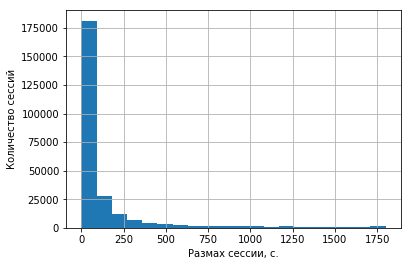

In [11]:
plt.hist(delta, bins=20)
plt.xlabel('Размах сессии, с.')
plt.ylabel('Количество сессий')
plt.grid(True)

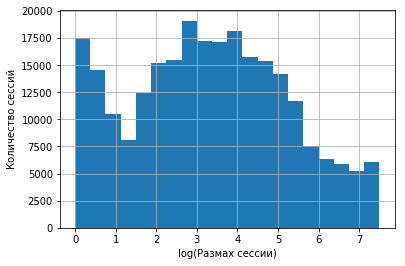

In [12]:
plt.hist(log_delta, bins=20)
plt.xlabel('log(Размах сессии)')
plt.ylabel('Количество сессий')
plt.grid(True)

Видно, что распределение размаха сессии имеет ярко выраженный экспоненциальный характер. Прологорифмировав его, получим распределение, больше похожее на нормальное (хоть и с левым выбросом). Тем самым мы сделали данные больше подходящими для стандартного скеллера и уменьшили разброс.

### Склеенные год, месяц и день

Разумно предположить, что информация о дате сессии улучшит обобщающую способность модели. Но изначально дата и время даются в виде строки. Если склеить год, месяц и день сессии, то получим целое число, которое обладает нужными свойствами даты. В качестве минуса можно отметить сильные скачки при обновлении года.

### Индикатор летней сессии

Данные были взяты с прокси сервера университета. Разумно предположить, что поведение пользователей будет меняться в зависимости от времени года. А сильнее всего во время летнего сезона отпусков. Добавление признака летней сессии заметно улучшило модель. При этом если добавить другие времена года, то качество снижается. Посмотрим на месяца целевых сессий.

ГодМесяц нецелевых сессий:

In [13]:
np.unique(train_df[train_df['target'] == 0]['time1'].apply(session_date).apply(lambda x: x // 100))

array([201301, 201302, 201303, 201304, 201305, 201306, 201307, 201308,
       201309, 201310, 201311, 201312, 201401, 201402, 201403, 201404])

ГодМесяц целевых сессий:

In [14]:
np.unique(train_df[train_df['target'] == 1]['time1'].apply(session_date).apply(lambda x: x // 100))

array([201302, 201304, 201309, 201311, 201312, 201401, 201402, 201403,
       201404])

Видно, что в целевых сессиях отсутствуют летние месяцы. Этим и можно объяснить полезность данного признака.

### Индикатор того, что время начала сессии входит в типичное для целевых сессий

Посмотрим, как отличаются целевые и нецелевые сессии с точки зрения часа начала сессии.

Нецелевые сессии:

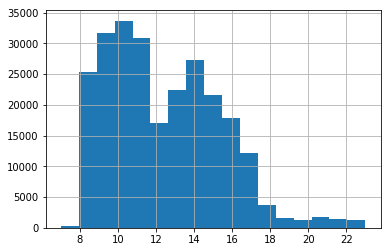

In [15]:
train_df['time1'][train_df['target'] == 0].apply(start_hour).hist(bins=17)

In [16]:
np.unique(train_df[train_df['target'] == 0]['time1'].apply(start_hour))

array([ 7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

Целевые сессии:

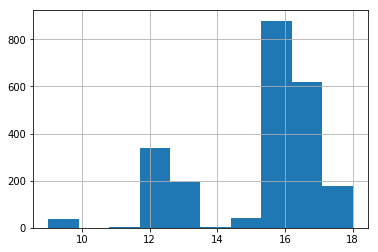

In [17]:
train_df[train_df['target'] == 1]['time1'].apply(start_hour).hist(bins=10)

In [18]:
np.unique(train_df[train_df['target'] == 1]['time1'].apply(start_hour))

array([ 9, 11, 12, 13, 14, 15, 16, 17, 18])

Видно, что распределение часа начала целевых сессий сильно отличается от распределения по нецелевым.

### День недели

Вполне очевидно, что день недели сессии в данной задаче будет хорошим признаком. Разные люди по-разному ведут себя относительно дней недели, особенно относительно выходных дней. Дни недели были закодированны через OHE.

Также возникла идея отфильтровать дни недели, типичные для целевых сессий. Однако оказалось, что целевые сессии распределены по всем дням недели. Попытка убрать непопулярные дни недели (например, воскресенье) лишь ухудшила модель.

Дни недели целевых сессий:

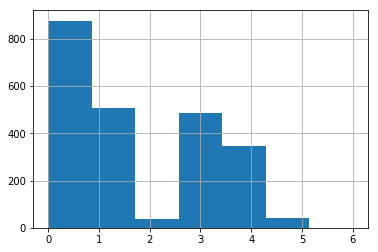

In [19]:
train_df[train_df['target'] == 1]['time1'].apply(weekday).hist(bins=7)

Дни недели нецелевых сессий:

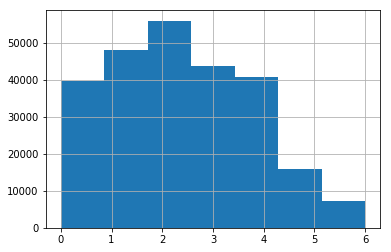

In [20]:
train_df[train_df['target'] == 0]['time1'].apply(weekday).hist(bins=7)

### Выбрасывание части обучающей выборки

При детальном изучении данных оказалось, что при отсечении старых данных меняется распределение часа начала целевых сессий. В частности, они перестают начинаться в 9 утра.

Все целевые сессии:

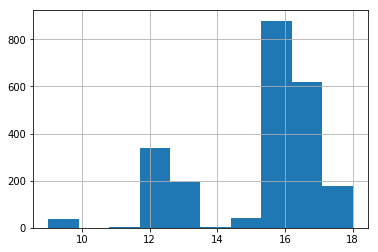

In [21]:
train_df[train_df['target'] == 1]['time1'].apply(start_hour).hist(bins=10)

In [22]:
np.unique(train_df[train_df['target'] == 1]['time1'].apply(start_hour))

array([ 9, 11, 12, 13, 14, 15, 16, 17, 18])

Целевые сессии с июня 2013 года:

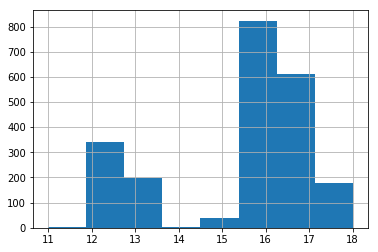

In [23]:
train_df[train_df['time1'] >= '2013-06-01 00:00:00'][train_df['target'] == 1]['time1'].apply(start_hour).hist(bins=8)

In [24]:
np.unique(train_df[train_df['time1'] >= '2013-06-01 00:00:00'][train_df['target'] == 1]['time1'].apply(start_hour))

array([11, 12, 13, 14, 15, 16, 17, 18])

In [25]:
train_df = train_df[train_df['time1'] >= '2013-06-01 00:00:00']

Можно объяснить этот эффект тем, что со временем пользователь поменял свое поведение. Изменились его привычки или жизненые обстоятельства, что повлекло изменения во времени сессий.

Если отказаться от использования старых данных, результат улучшается.

### Масштабирование

К количественным признакам было применено масштабирование для лучшей сходимости. Масштабировалось все с помощью Standard Scaler, который вычитает среднее и делит на СКО. Скелер обучался только на трейне.

Также пробовался Robust Scaler из-за теоретически лучшей работы на распределениях с выбросами. Однако к лучшим результатам это не привело.

### Добавляем новые признаки и масштабируем

In [26]:
train_df['weekday'] = train_df['time1'].apply(weekday)
train_df['session_date'] = train_df['time1'].apply(session_date)
session_len, _, _, log_delta = session_len__unique_part__delta(train_df)
train_df['session_len'] = session_len
train_df['log_delta'] = log_delta
train_df['summer'] = train_df['time1'].apply(summer)
train_df['alice_time'] = train_df['time1'].apply(alice_time)

test_df['weekday'] = test_df['time1'].apply(weekday)
test_df['session_date'] = test_df['time1'].apply(session_date)
session_len, _, _, log_delta = session_len__unique_part__delta(test_df)
test_df['session_len'] = session_len
test_df['log_delta'] = log_delta
test_df['summer'] = test_df['time1'].apply(summer)
test_df['alice_time'] = test_df['time1'].apply(alice_time)


scaling_features = ['weekday', 'session_date', 'session_len', 'log_delta']
all_new_features = ['weekday', 'session_date', 'session_len', 'log_delta', 'summer', 'alice_time']

HBox(children=(IntProgress(value=0, max=238706), HTML(value='')))

HBox(children=(IntProgress(value=0, max=82797), HTML(value='')))

In [27]:
sc = StandardScaler()
train_df[scaling_features] = sc.fit_transform(train_df[scaling_features].values)
test_df[scaling_features] = sc.transform(test_df[scaling_features].values)

Объединяем обучающую и тестовую выборки и кодируем дни недели:

In [28]:
train_test_df = pd.concat([train_df, test_df])
train_test_df = pd.concat([train_test_df, pd.get_dummies(train_test_df['weekday'])], axis=1)
train_test_df.columns = train_test_df.columns[:-7].append(pd.Index([str(i) for i in range(7)]))

In [29]:
#добавляем в список признаков кодированные дни недели
for i in range(7):
    all_new_features.append(str(i))

Получившийся набор новых признаков:

In [30]:
for f_k, f_v in enumerate(all_new_features):
    print(f_k, f_v)

0 weekday
1 session_date
2 session_len
3 log_delta
4 summer
5 alice_time
6 0
7 1
8 2
9 3
10 4
11 5
12 6


### Bag of sites и tf-idf

К сайтам сессий был применен подход bag of words, который часто применяется в анализе текстов. Будем считать документом сессию, а словом в документе – сайт. В этом подходе игнорируется порядок сайтов в сессии.

В этом приближении вполне применима мера tf-idf. Будем считать ее, в том числе, на биграммах – парах подряд идущих сайтов.

Оказалось, что лучшие результаты дает параметр binary=True. При этом значении не учитвается частотность сайта, а только его наличие.

Также был оптимизирован гипермараметр min_df. Это позволило значительно уменьшить размерность итогового признакого пространства и отбросить совсем непопулярные сайты.

In [31]:
corpus = history_string(train_test_df)
vectorizer = TfidfVectorizer(ngram_range=(1,2),
                             norm='l2',
                             token_pattern='\w+',
                             min_df=1.842070e-05,
                             binary=True,
                             use_idf=True)

HBox(children=(IntProgress(value=0, max=321503), HTML(value='')))

## Выбор модели

Сначала был выбран SGDClassifier с логистической функцией потерь. Это решение было сделано на основе того, что мы имеем задачу бинарной классификации в пространстве большой размерности с сильно разреженными признаками.

В дальнейшем была взята просто логистическая регрессия, которая показала лучшие результаты. Гиперпараметр C был оптимизирован до значения 5.

In [32]:
model = LogisticRegression(random_state=17, n_jobs=-1, C=5)

## Кросс-валидация

Данные задачи имеют четкую зависимость от времени, поэтому обычная кросс-валидация тут не подходит. Используем Time Series Cross Validation на 5 фолдах.

In [33]:
tscv = TimeSeriesSplit(n_splits=7)

In [34]:
feature_list = [i for i in range(1,13)]
y = train_test_df[train_test_df['target'] >= 0]['target'].values
X_len = len(train_test_df[train_test_df['target'] >= 0])
additional_features = csr_matrix(train_test_df[all_new_features])
logreg = LogisticRegressionCV(cv=tscv, random_state=17, n_jobs=-1, penalty='l2', scoring='roc_auc', Cs=[5], solver='liblinear')
tfidf = vectorizer.fit_transform(corpus)
X = csr_matrix(hstack((tfidf[:X_len], additional_features[:X_len, feature_list])))
logreg.fit(X, y)

LogisticRegressionCV(Cs=[5], class_weight=None,
           cv=TimeSeriesSplit(max_train_size=None, n_splits=7), dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=-1, penalty='l2', random_state=17,
           refit=True, scoring='roc_auc', solver='liblinear', tol=0.0001,
           verbose=0)

In [35]:
print("mean score: {}, std: {}".format(logreg.scores_[1].mean(), logreg.scores_[1].std()))

mean score: 0.9073932985478975, std: 0.054496485626562556


## Предсказание на тестовой выборке

In [36]:
feature_list = [i for i in range(1,13)]
y = train_test_df[train_test_df['target'] >= 0]['target'].values
X_len = len(train_test_df[train_test_df['target'] >= 0])
additional_features = csr_matrix(train_test_df[all_new_features])
tfidf = vectorizer.fit_transform(corpus)
X = csr_matrix(hstack((tfidf[:X_len], additional_features[:X_len, feature_list])))
model.fit(X, y)
test_pred_proba = model.predict_proba(csr_matrix(hstack((tfidf[X_len:], additional_features[X_len:, feature_list]))))[:, 1]

In [37]:
write_to_submission_file(test_pred_proba, 'test_pred.csv')

На публичном лидерборде предсказания модели получают оценку 0.95156 по ROC-AUC.

## Применимость модели

Модель получила достаточно высокую оценку качества. На практике ее можно применить для идентификации пользователя, который использует vpn или proxy для сокрытия своей личности. Можно идентифицировать пользователей в местах с публичным доступом в интернет. Можно идентифицировать членов семьи за общим компьютером.

## Пути улучшения модели

* Oversampling для целевых сессий
* Стекинг, блендинг
* Рекурентные нейронные сети
* Использование информации в самих сайтах: доменные зоны, уровень сайта, протокол
* Тематическое моделирование над сайтами
* Использование иной информации с сайтов